In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
import numpy as np
import open3d as o3d
import torch
from skimage import measure
from tqdm import tqdm, trange

from core.dataset import ScanNet
from core.integrate import PanopticFusionScalableTSDFVolume

draw = o3d.visualization.EV.draw

In [5]:
tsdf_device = "cuda:1"
tsdf_volume = PanopticFusionScalableTSDFVolume(
    voxel_size=0.015,
    sdf_trunc=0.075,
    margin=0.08,
    device=tsdf_device,
)

load_dir = "/home/quanta/Experiments/feature-instance-fusion/scannet_scene0000_00/"
tsdf_volume.load(load_dir + "tsdf/tsdf_volume.pt")

In [22]:
tsdf_volume.reset_instance()
tsdf_volume.load_instance(load_dir + 'tsdf_guided_panoptic_grounded_sam/panoptic_labels.pt')

In [23]:
connected_componet_label = torch.load(load_dir + "graph_connect_etx-grounded_sam_kmeans-ext-random_grounded_sam_SVP/merged_labels.pt").to(tsdf_device)
print(connected_componet_label.shape, tsdf_volume._instance.shape)

torch.Size([2087396]) torch.Size([2087396])


In [34]:
tsdf_volume._instance = connected_componet_label

In [35]:
verts, faces = tsdf_volume.extract_mesh()
mesh = o3d.geometry.TriangleMesh(
    vertices=o3d.utility.Vector3dVector(verts),
    triangles=o3d.utility.Vector3iVector(faces),
)
labels, labels_w_sum = tsdf_volume.extract_label_on_grid(verts)

<BarContainer object of 100 artists>

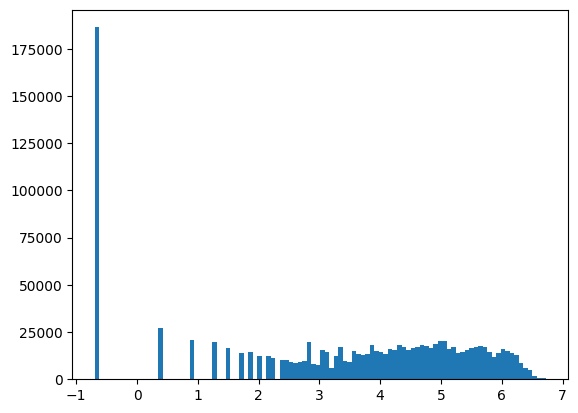

In [31]:
import matplotlib.pyplot as plt

plt.hist(np.log(labels_w_sum), bins=100)[2]
# plt.hist(labels_w_sum, bins=100)[2]

In [26]:
color_set = np.random.random(size=(1025, 3))
color_set[0, :] = 1.0

In [36]:
# new_label = labels + 0
# new_label[labels_w_sum < 5] = 0
# color = color_set[new_label]
color = color_set[labels]
mesh.vertex_colors = o3d.utility.Vector3dVector(color)

In [33]:
draw([mesh])